# Multi-Omics Integration for Personalized Medicine Using MOFA

In this notebook, you'll explore a multi-omic dataset of Chronic Lymphocytic Leukemia patients using Multi-Omics Factor Analysis (MOFA) with the MOFA-FLEX package. MOFA-FLEX is a factor model framework that combines functionalities from various previously published methods, including MOFA.

## Prerequisites

Before getting started, ensure that you're familiar with the Python packages used in this tutorial. Below you can find links for short introductions.
- [NumPy](https://numpy.org/doc/2.2/user/quickstart.html)
- [Pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
- [AnnData](https://anndata.readthedocs.io/en/stable/tutorials/notebooks/getting-started.html)
- [ScanPy](https://scanpy.readthedocs.io/en/stable/tutorials/index.html)
- [Plotnine](https://plotnine.org/guide/overview.html) (similar to ggplot2 in R)

In [46]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import plotnine as p9
import gseapy as gp
from scipy.stats import pearsonr
from sklearn.neighbors import KNeighborsClassifier

import mofaflex as mf

## Loading and Examining the Data

The data consists of measurements of four modalities:
- In vitro drug response
- Methylation
- mRNA
- Somatic mutations

The data has already been prepared and is available as `.h5ad` files, which you can load using AnnData's `read_h5ad` function.

In [143]:
adata_drugs = ad.read_h5ad("data/Drugs.h5ad")
adata_methylation = ad.read_h5ad("data/Methylation.h5ad")
adata_mrna = ad.read_h5ad("data/mRNA.h5ad")
adata_mutations = ad.read_h5ad("data/Mutations.h5ad")

### Exercise
1. Examine the AnnData objects for the different modalities. Do they share the same observations or features?
2. Get a feeling for the values in the individual modalities. It's always a good idea to plot their distribution. Why? When do you have to apply further preprocessing before continuing with the actual analysis?

In [3]:
print("Drugs: ", adata_drugs)
print("Methylation: ", adata_methylation)
print("mRNA: ", adata_mrna)
print("Mutations: ", adata_mutations)

Drugs:  AnnData object with n_obs × n_vars = 184 × 310
    obs: 'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12'
Methylation:  AnnData object with n_obs × n_vars = 196 × 4248
    obs: 'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12'
mRNA:  AnnData object with n_obs × n_vars = 136 × 5000
    obs: 'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12'
Mutations:  AnnData object with n_obs × n_vars = 200 × 69
    obs: 'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12'


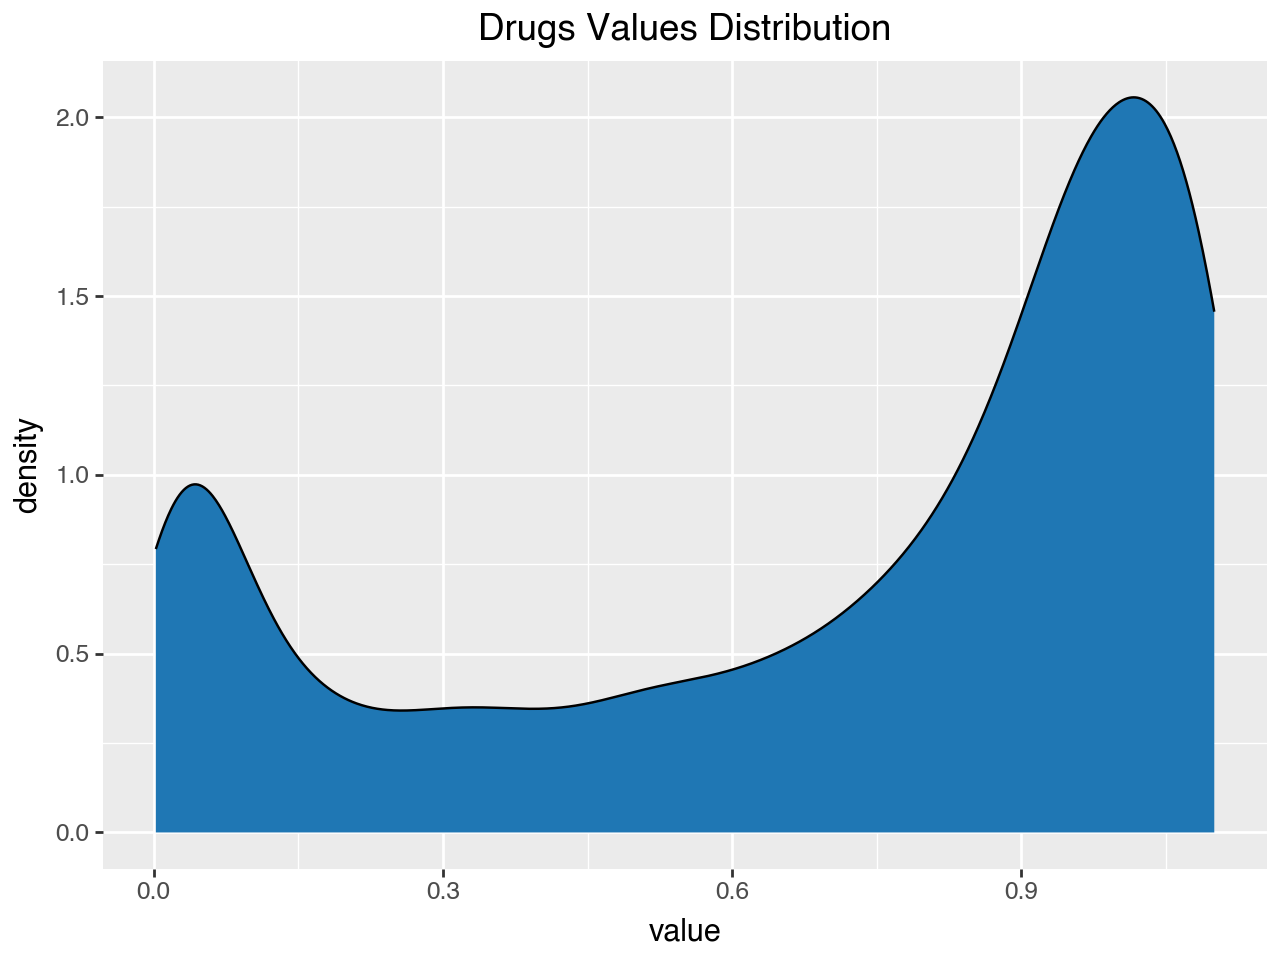

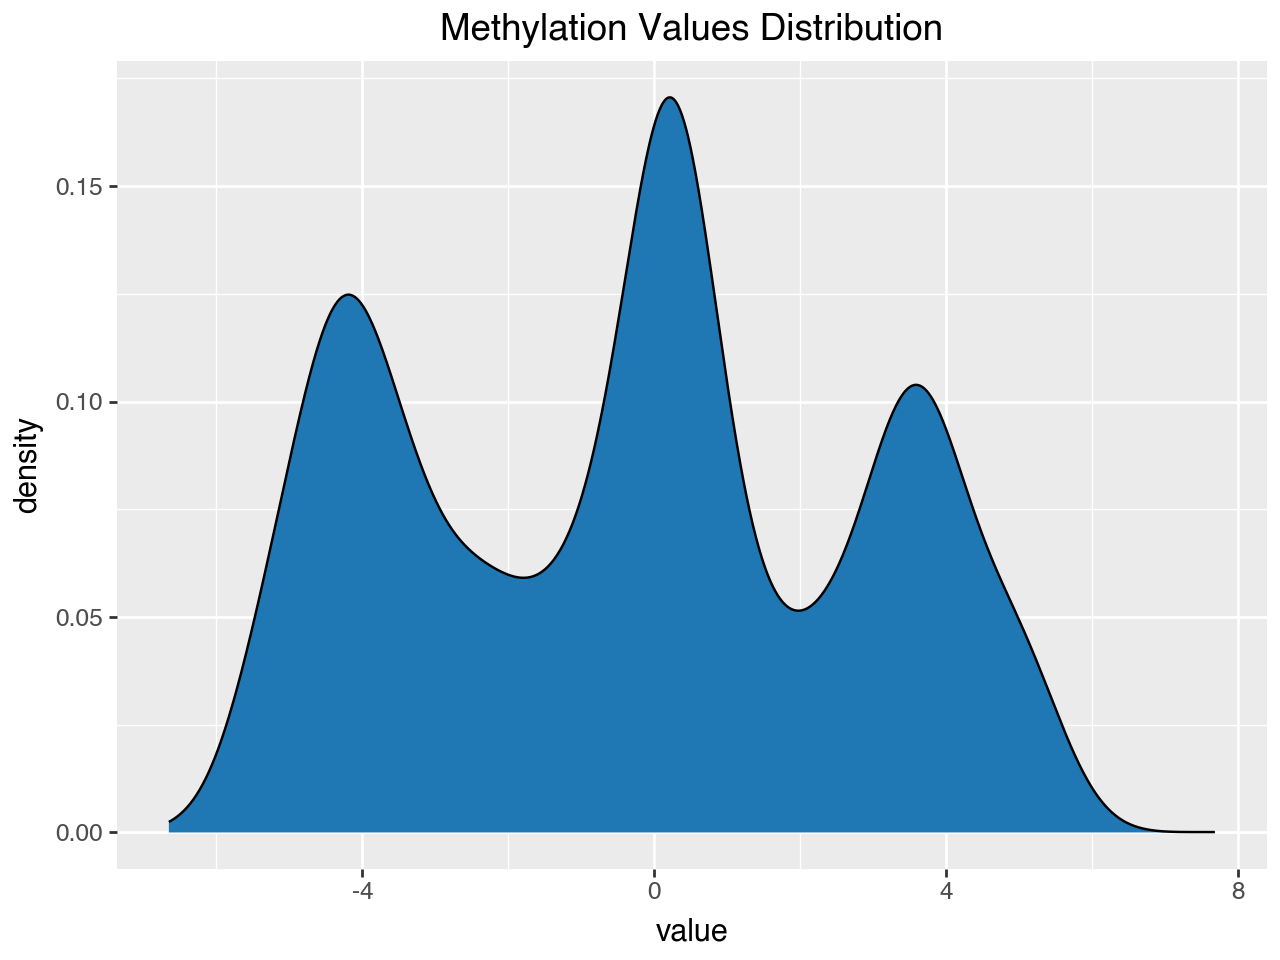

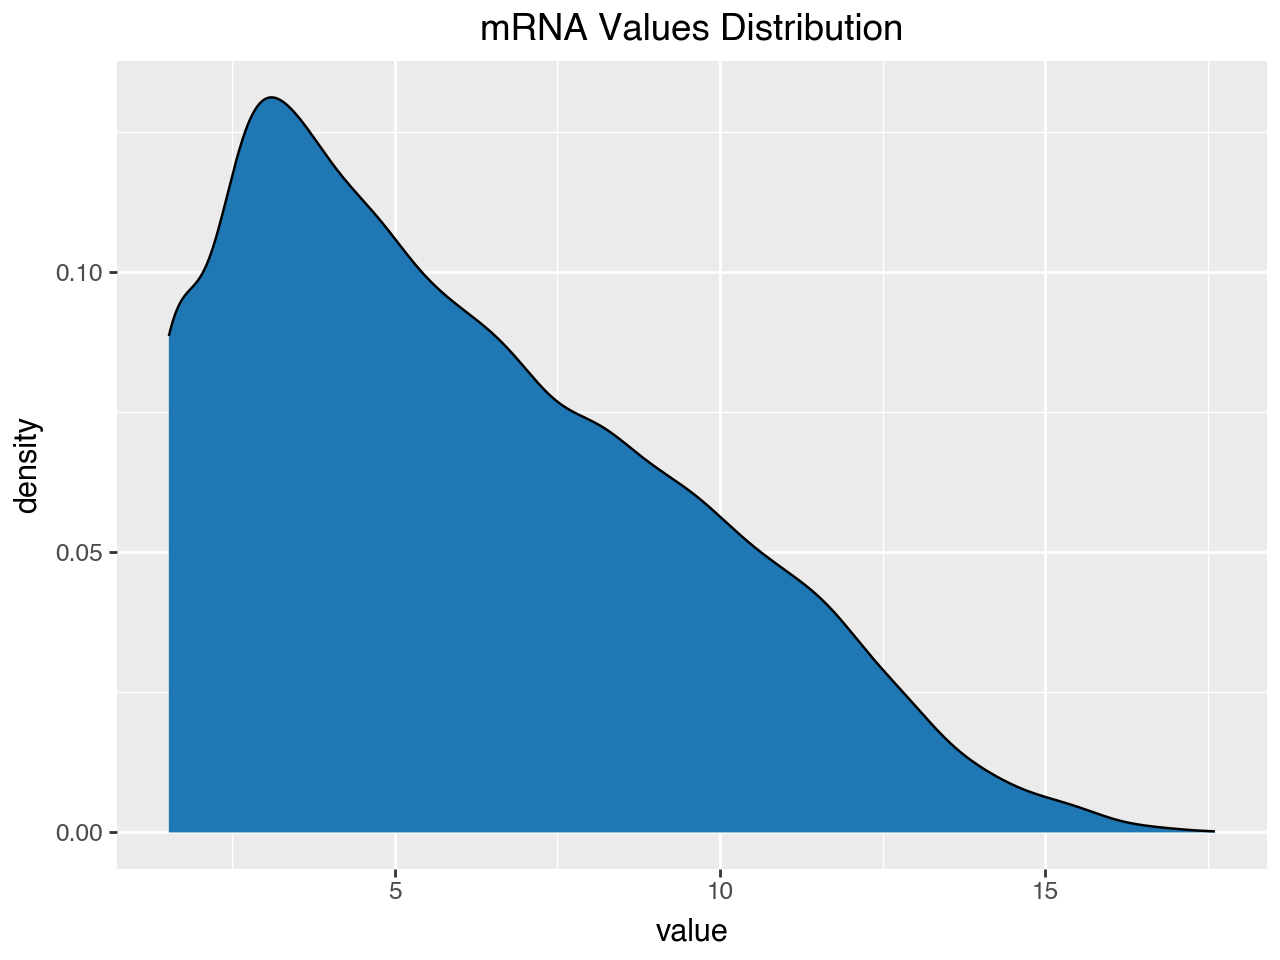

/opt/homebrew/envs/course/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 3370 rows containing non-finite values.


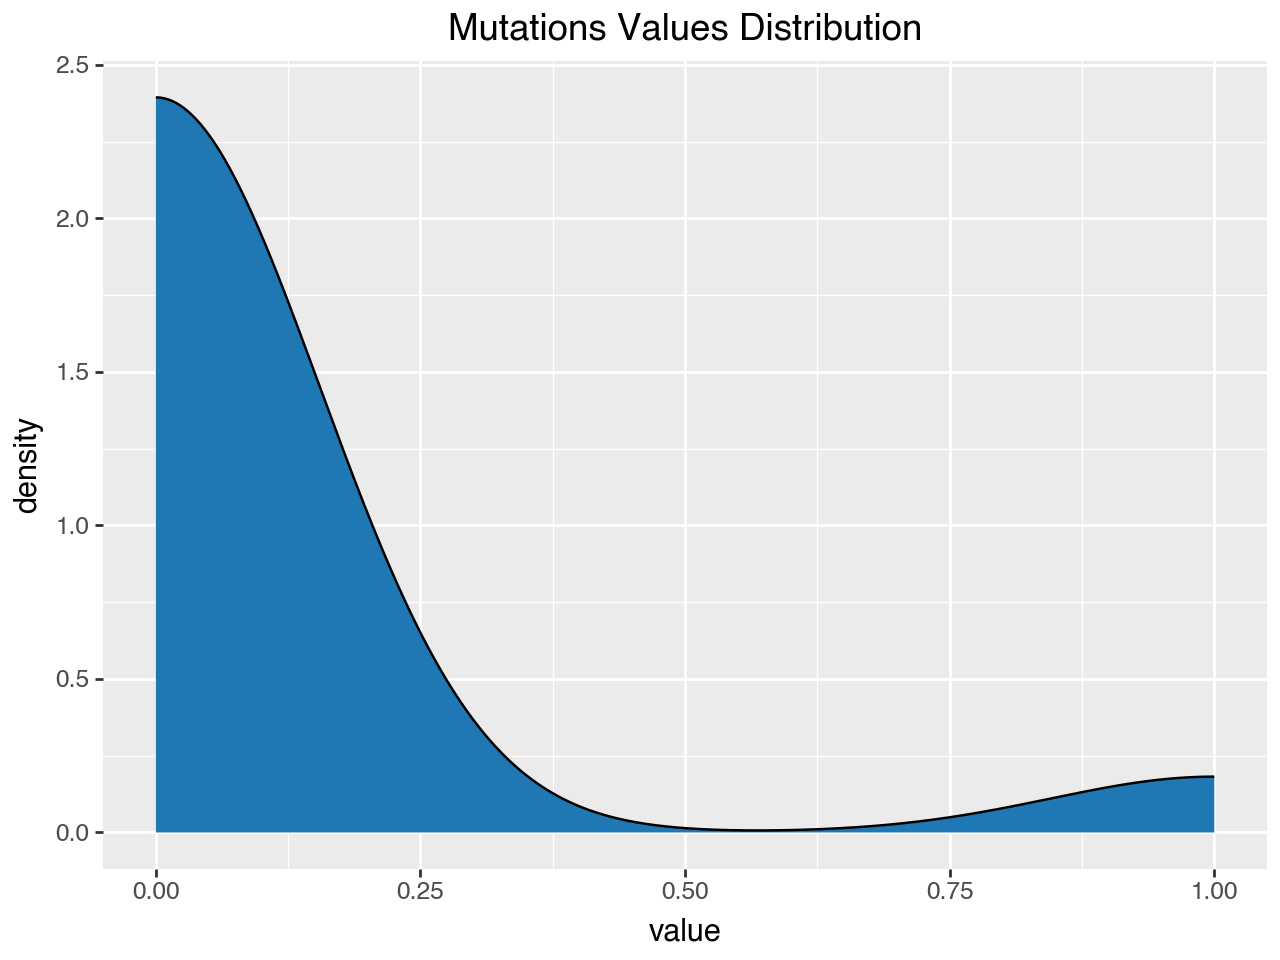

In [4]:
def plot_values_distribution(adata, title=None):
    df_plot = pd.DataFrame({"value": adata.X.flatten()}).sample(10000)

    plot = (
        p9.ggplot(df_plot, p9.aes(x="value"))
        + p9.geom_density(fill="C0")
        + p9.labs(title=title)
    )
    plot.show()

plot_values_distribution(adata_drugs, title="Drugs Values Distribution")
plot_values_distribution(adata_methylation, title="Methylation Values Distribution")
plot_values_distribution(adata_mrna, title="mRNA Values Distribution")
plot_values_distribution(adata_mutations, title="Mutations Values Distribution")

## Training a MOFA-FLEX Model

MOFA-FLEX assumes input data that is structured into observation groups ("groups") and variable groups ("views"), as shown in [Figure 1a of the MOFA+ paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1/figures/1). Views can e.g. be different measurement modalities like RNA and DNA. This structure is represented as a nested Python dictionary of AnnData objects. The outer level represents the groups, while the inner level represents the views:

`input_data = {"group_1": {"view_1": adata_g1_v1, "view_2": adata_g1_v2}, "group_2": {"view_1": adata_g2_v1, "view_2": adata_g2_v2}}`

### Exercise:
Prepare the CLL input data for MOFA-FLEX. Note that there is only one observation group.

In [5]:
data = {"group_1": {
    "drugs": adata_drugs,
    "methylation": adata_methylation,
    "mrna": adata_mrna,
    "mutations": adata_mutations
}}

MOFA-FLEX can be used in many different configurations and needs to be configured to work well with the specifics of a particular data set. A new MOFA-FLEX model is instantiated and trained using the `mf.MOFAFLEX` class. To configure the model, Options classes are used: `mf.DataOptions`, `mf.ModelOptions`, `mf.TrainingOptions` and `mf.SmoothOptions`. Read more about the different possibilities in the [documentation](https://mofaflex.readthedocs.io/latest/api/index.html).

### Exercise
Train a MOFA-FLEX model on the CLL data. You'll want to use this configuration (everything else should be default values):
- 10 factors
- Horseshoe weight prior
- Normal likelihood for all views
- Training for no more than 10 000 epochs
- Learning rate of 0.05
- Early stopping patience of 1000 epochs
- Save the model with your favourite file name

You'll see that you also get a nice overview of the data structure before training starts.
While the model is training, why don't you have a look into the [original MOFA paper](https://www.embopress.org/doi/full/10.15252/msb.20178124)? Look for the supplementary methods if you're interested in learning more about the statistics involved.

In [6]:
# model = mf.MOFAFLEX(
#     data,
#     mf.ModelOptions(n_factors=10, weight_prior="Horseshoe", likelihoods="Normal"),
#     mf.TrainingOptions(lr=0.05, early_stopper_patience=1000, max_epochs=10000, save_path="results/model.h5"),
# )

model = mf.MOFAFLEX.load("results/model.h5")

One of the first things you'll want to look at after model training has finished is how meaningful the factors are that were found. A good measure for this is the explained variance per factor. It tells you how much of the observed variance in a given view is explained by an individual factor. MOFA-FLEX can create a plot of this quantity with the `mf.pl.variance_explained` function.

Other important checks are the convergence of the training loss curve and the factor correlation. The factor correlation is a cross correlation matrix of individual factors, showing the user how similar the factors are to each other. 

### Exercise
1. Make a variance explained plot and explain what you're seeing!
2. Can you find the relevant functions in `mf.pl` for plotting the training loss curve and the factor correlation? Do the plots look good?

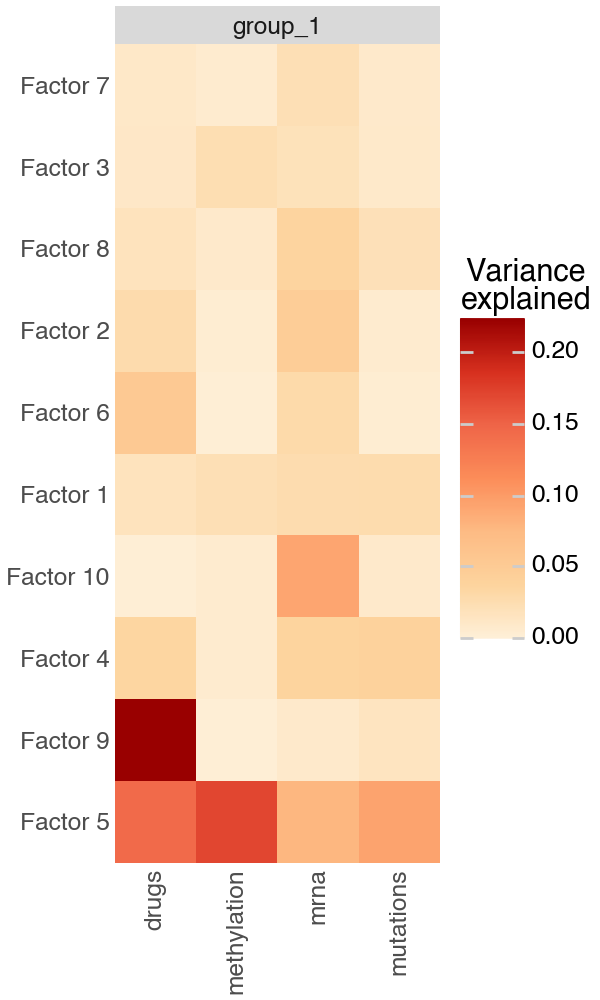

In [7]:
mf.pl.variance_explained(model)

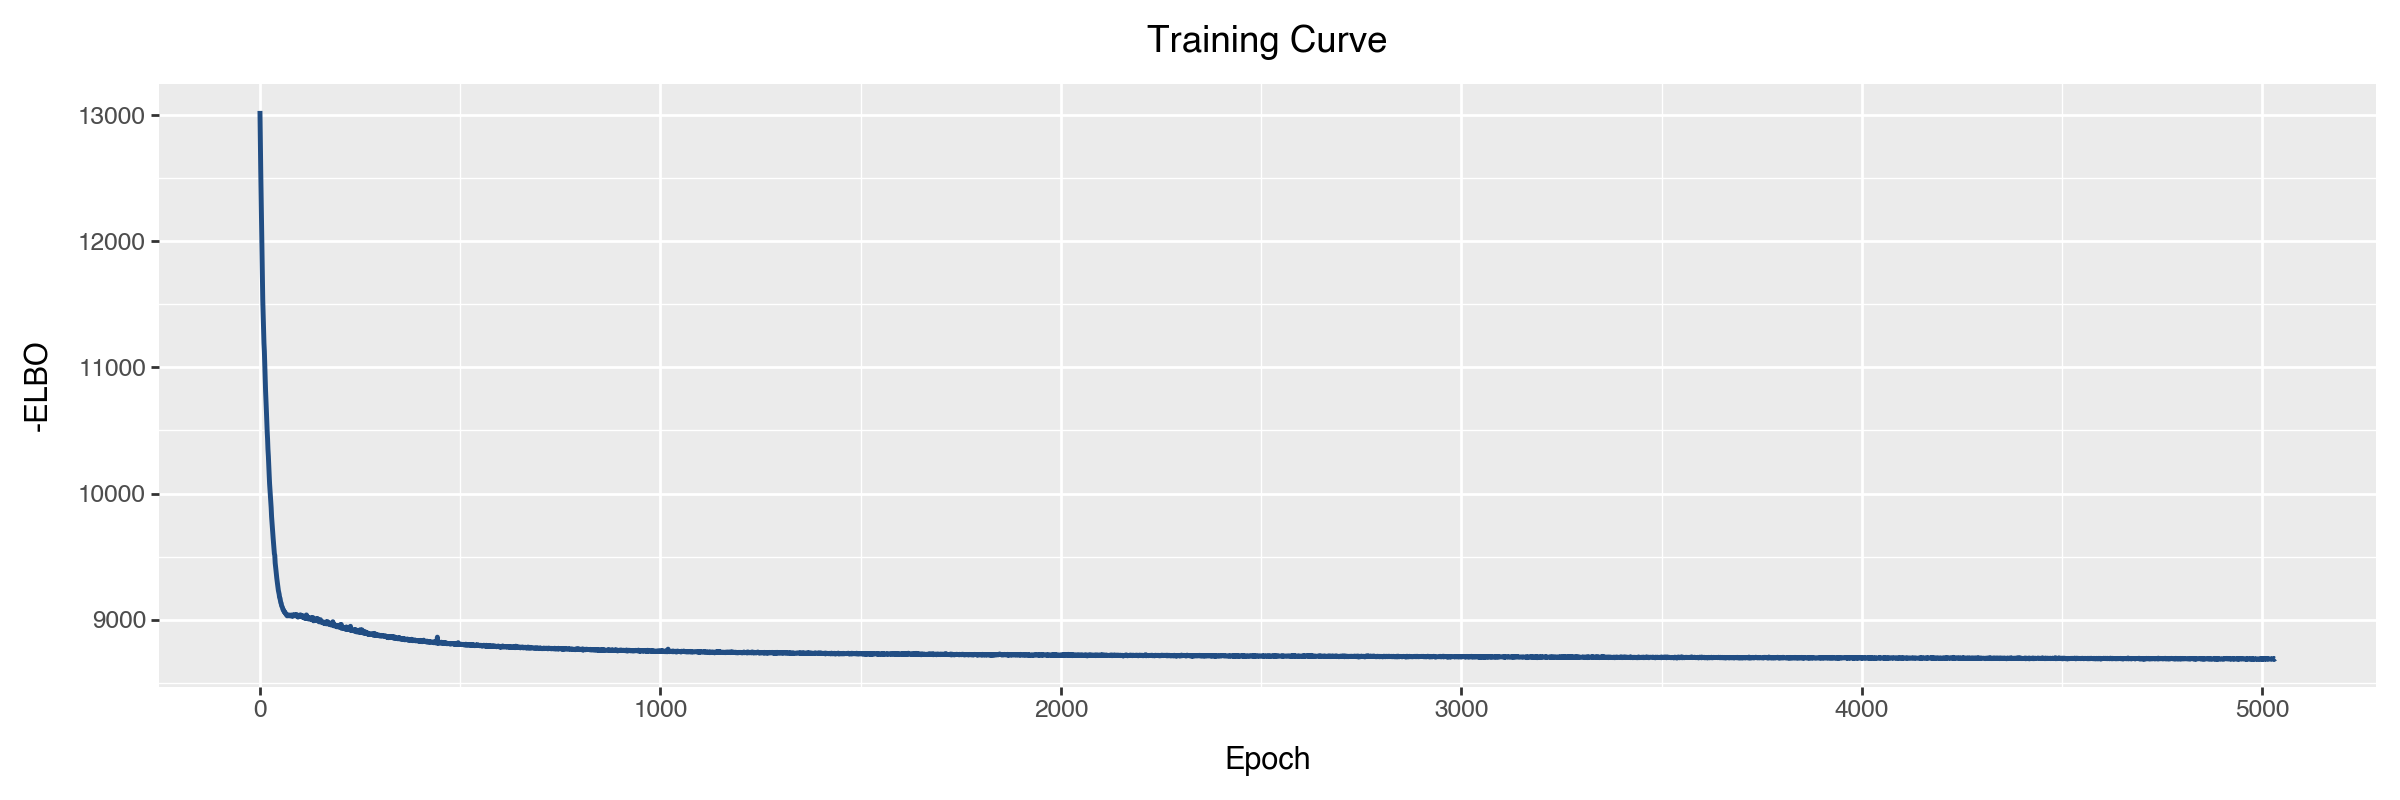

In [8]:
mf.pl.training_curve(model)

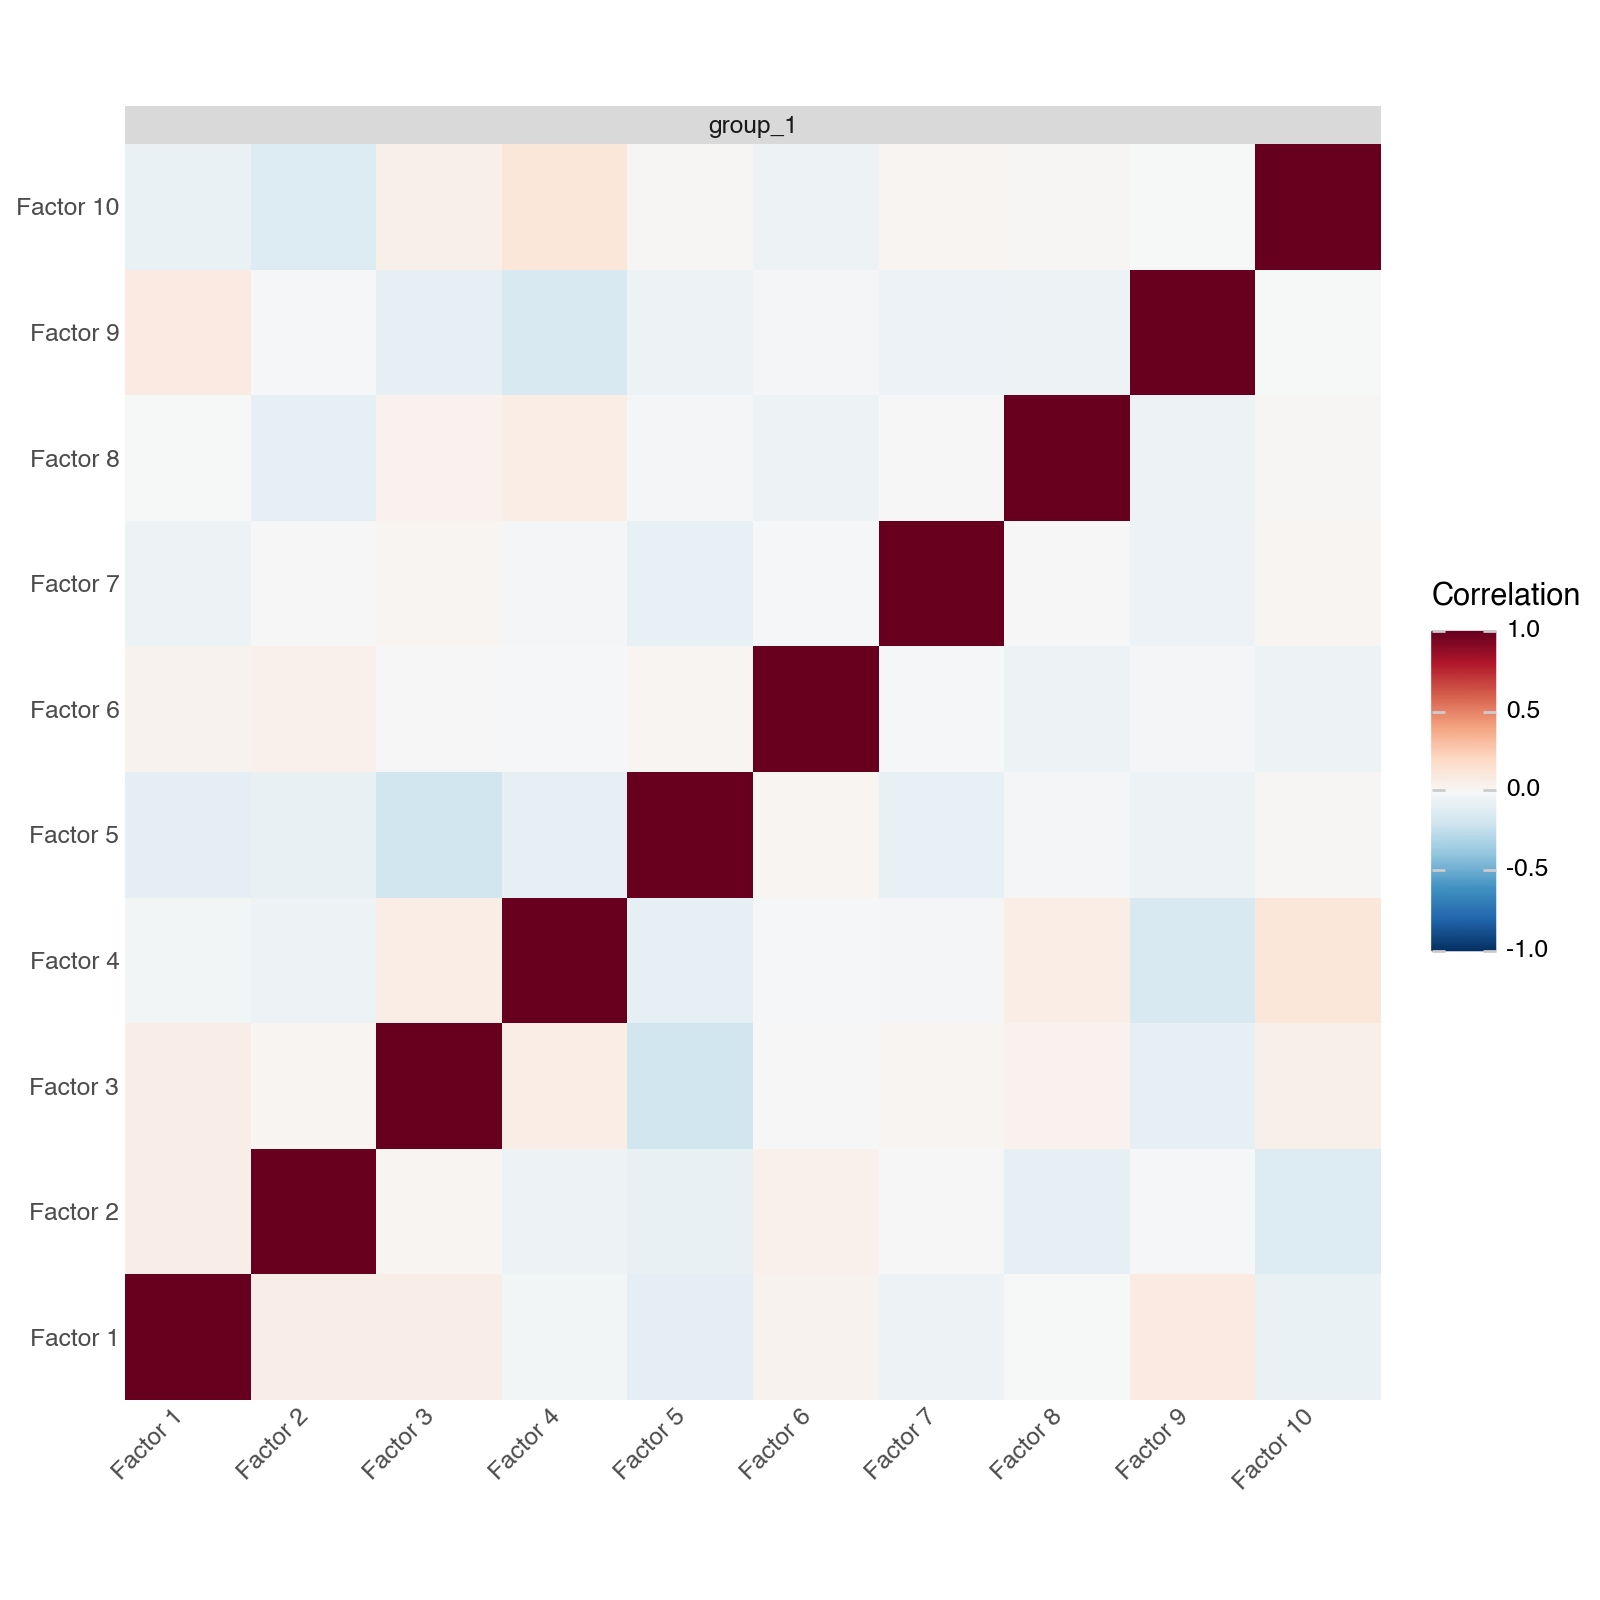

In [9]:
mf.pl.factor_correlation(model)

## Choosing the right number of factors
The number of factors used in a MOFA-FLEX model is a user choice which can have some influence on the outcome.

### Exercise
1. Train a MOFA-FLEX model with a smaller number of factors and re-do the analysis from above. Make sure to give it another name (and save to another file) to have access to both models afterwards. Do you see any difference?
2. What could be consequences of choosing too many or too few factors?

In [10]:
# model_small = mf.MOFAFLEX(
#     data,
#     mf.ModelOptions(n_factors=5, weight_prior="Horseshoe", likelihoods="Normal"),
#     mf.TrainingOptions(lr=0.05, early_stopper_patience=1000, max_epochs=10000, save_path="results/model_small.h5"),
# )

model_small = mf.MOFAFLEX.load("results/model_small.h5")

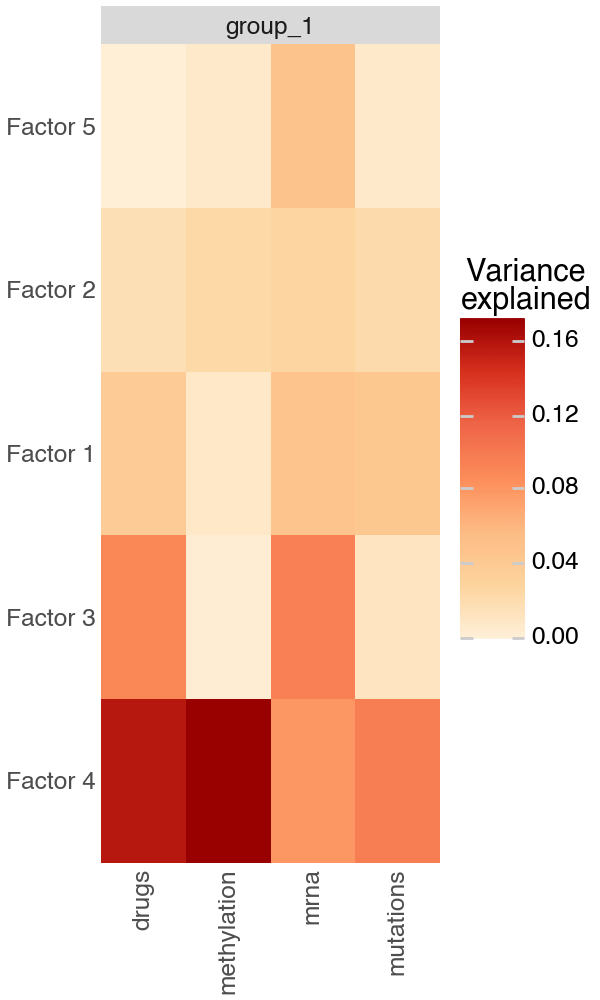

In [11]:
mf.pl.variance_explained(model_small)

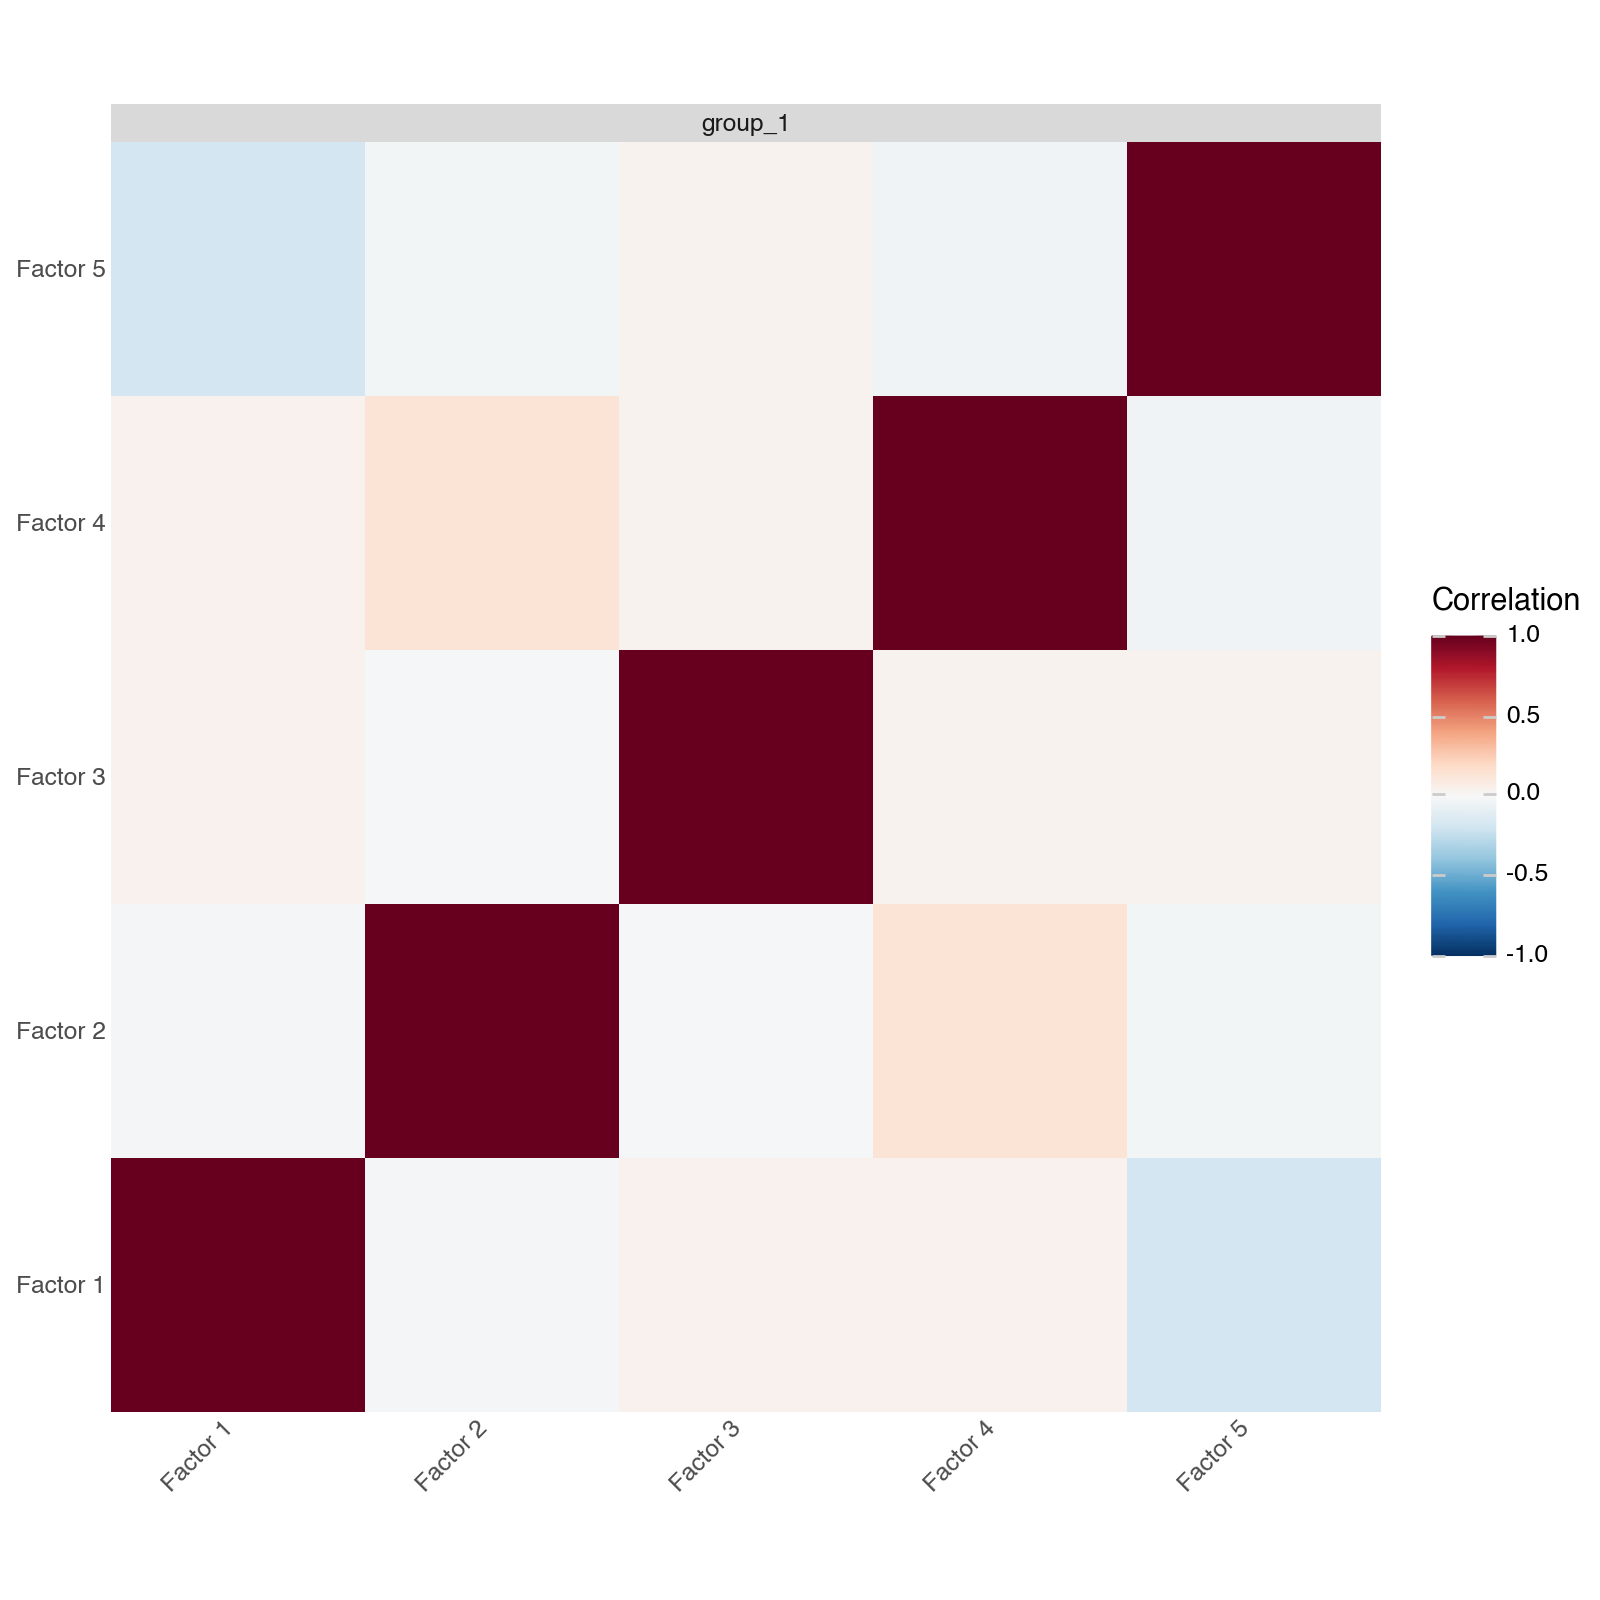

In [12]:
mf.pl.factor_correlation(model_small)

## Examining the factor weights and scores of the trained model

Now we'll want to have a closer look at the two main results of a MOFA-FLEX analysis:
1. Factor weights (matrix of shape `(n_observations, n_factors)`), representing the activity of individual factors in each observation
2. Factor scores (matrix of shape `(n_variables, n_factors)`), linking the low-dimensional factors to the high-dimensional original variables (e.g. genes)

We're sometimes a bit sloppy with the language and refer to the factors scores simply as "factors", and to the factor weights as "weights".

### Exercise
1. The factor scores and weights are obtained from the MOFA-FLEX model instance using the `.get_factors()` and `.get_weights()` methods, respectively. Try this out and validate the dimensions of the two matrices. Why do you get dictionaries from these methods and how are they structured?
2. To get a very quick overview, make heatmaps of the two matrices. There is no inbuilt method for this (use plotnine or your favourite plotting library).

In [13]:
factors = model.get_factors()
weights = model.get_weights()

print("Factors shape: ", factors["group_1"].shape)
print("Weights (Drugs) shape: ", weights["drugs"].shape)
print("Weights (Methylation) shape: ", weights["methylation"].shape)
print("Weights (mRNA) shape: ", weights["mrna"].shape)
print("Weights (Mutations) shape: ", weights["mutations"].shape)

Factors shape:  (200, 10)
Weights (Drugs) shape:  (10, 310)
Weights (Methylation) shape:  (10, 4248)
Weights (mRNA) shape:  (10, 5000)
Weights (Mutations) shape:  (10, 69)


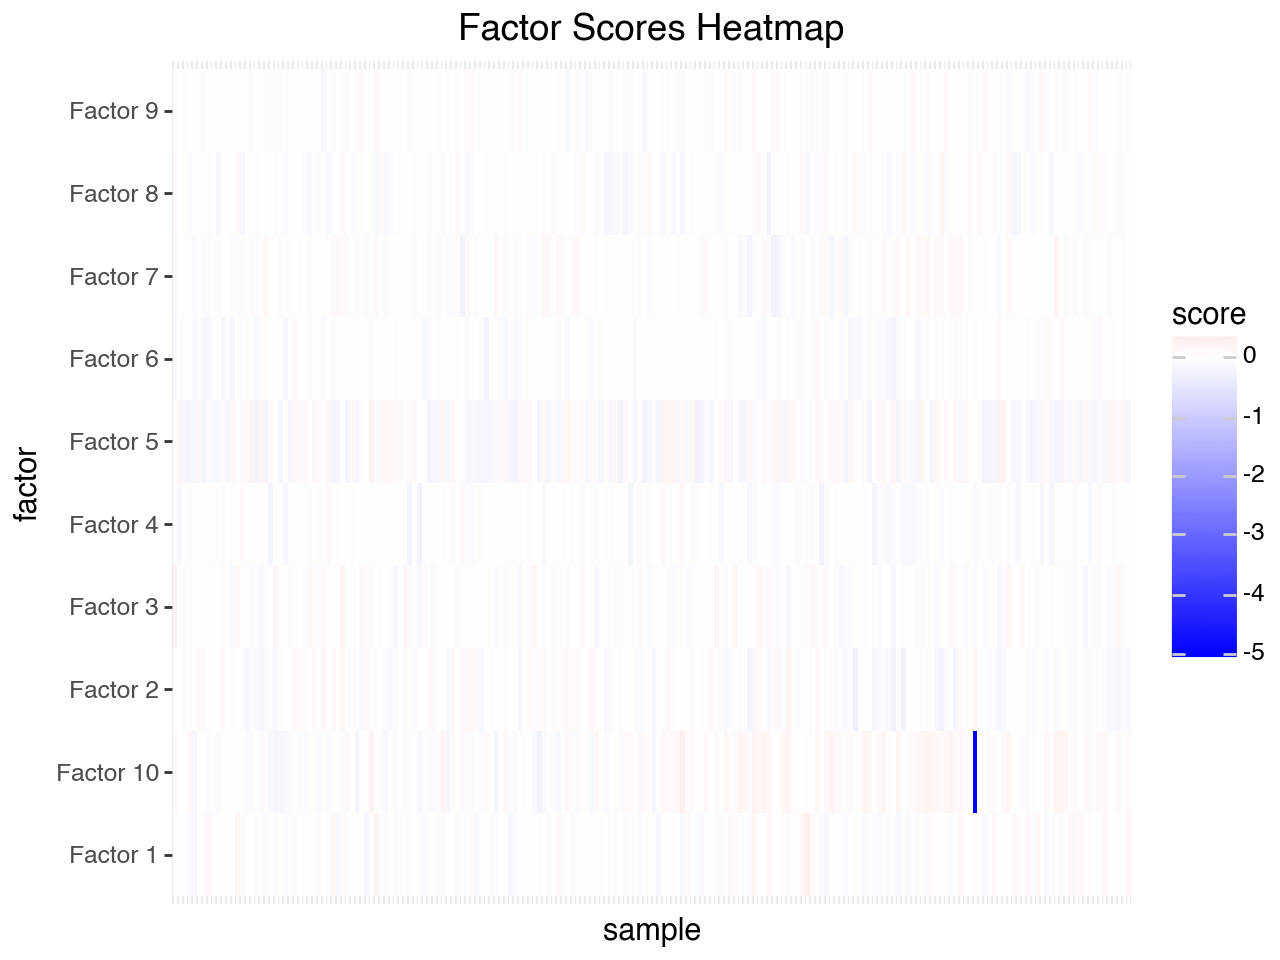

In [14]:
df_plot = factors["group_1"].reset_index(names="sample").melt(id_vars="sample", var_name="factor", value_name="score")

plot = (
    p9.ggplot(df_plot, p9.aes(x="sample", y="factor", fill="score"))
    + p9.geom_tile()
    + p9.scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0)
    + p9.theme(axis_text_x=p9.element_blank(), axis_ticks_x=p9.element_blank())
    + p9.labs(title="Factor Scores Heatmap")
)
plot.show()

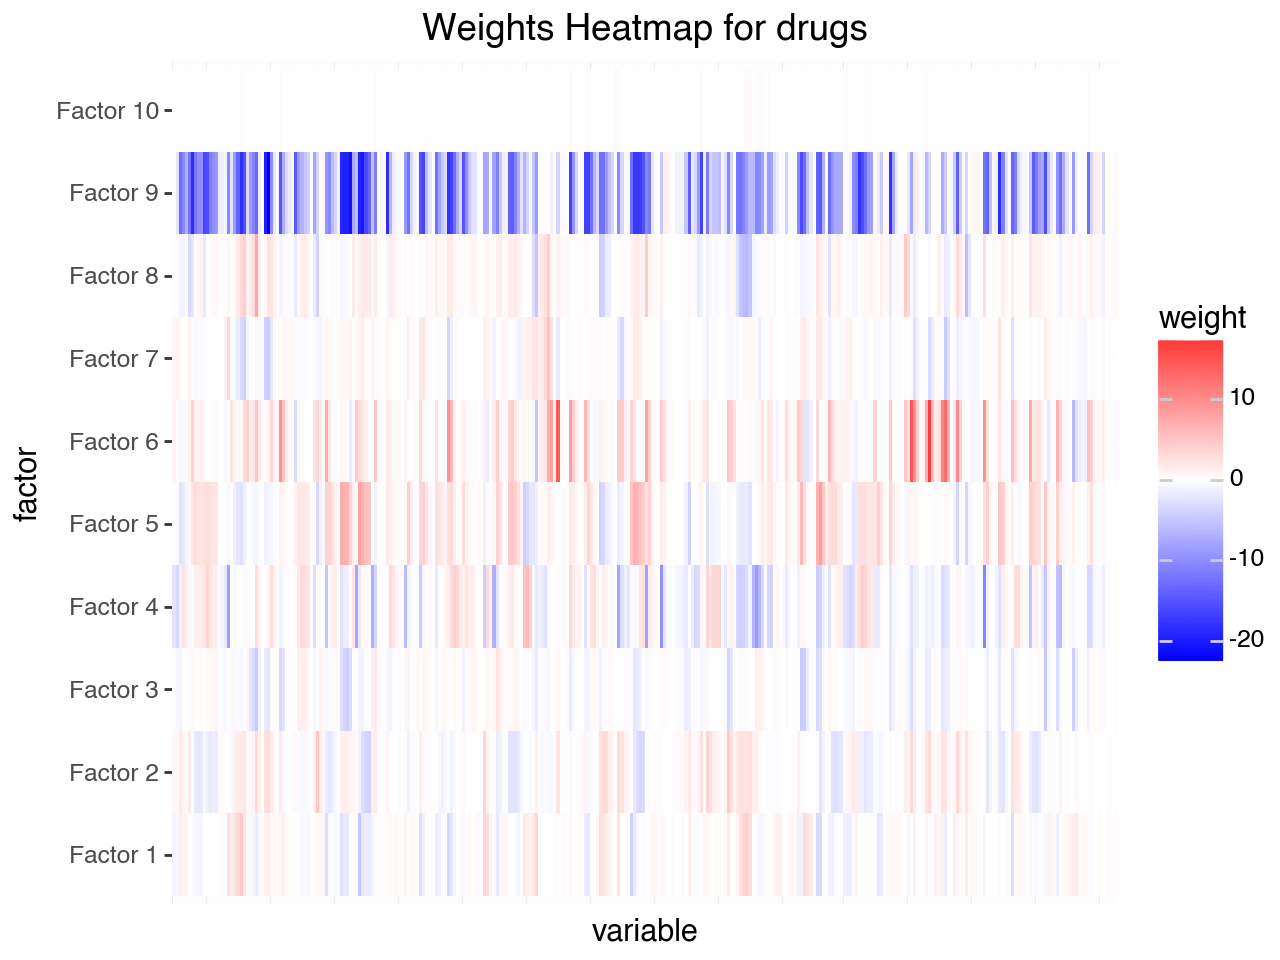

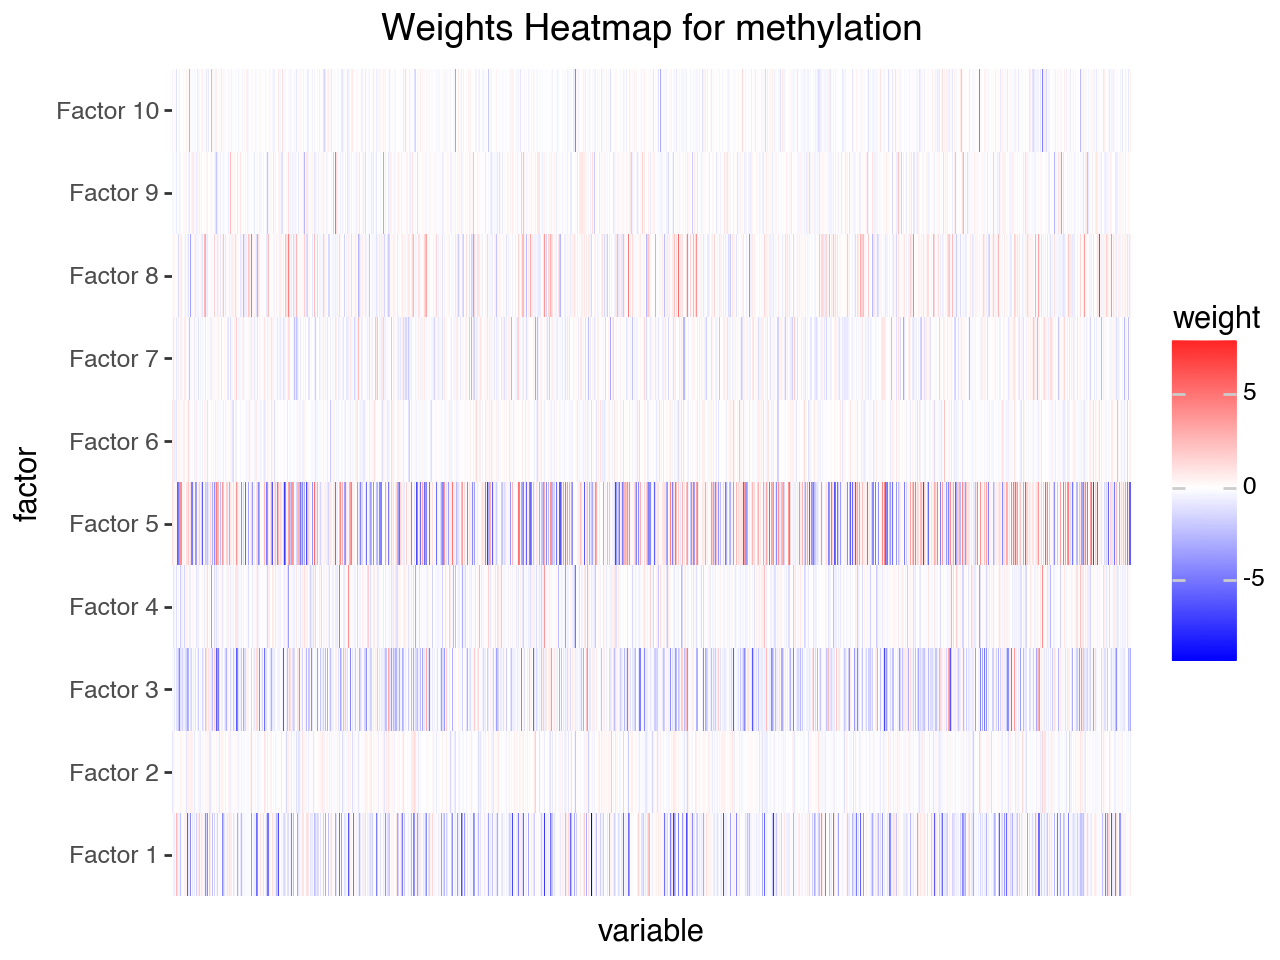

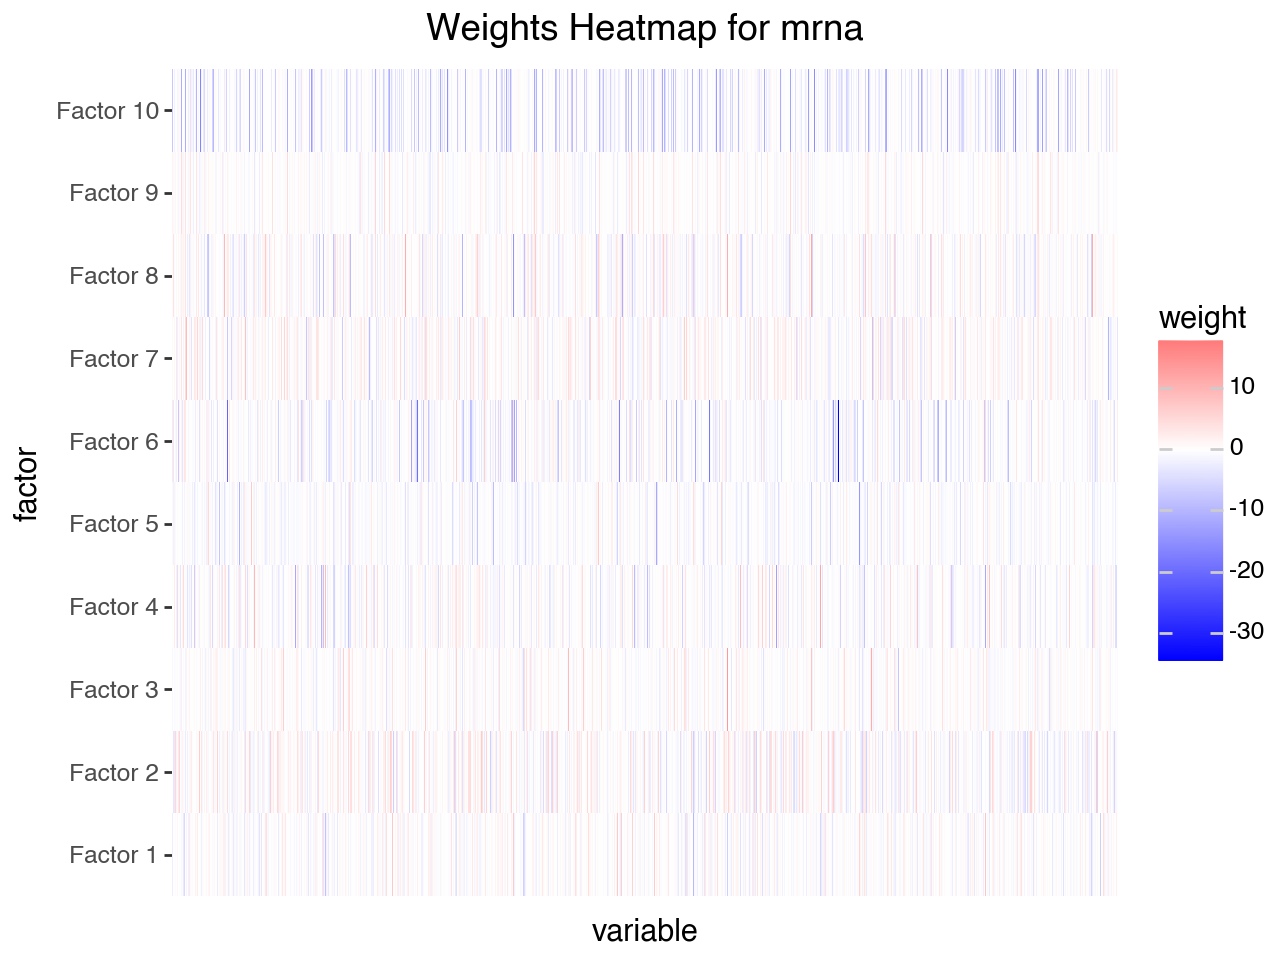

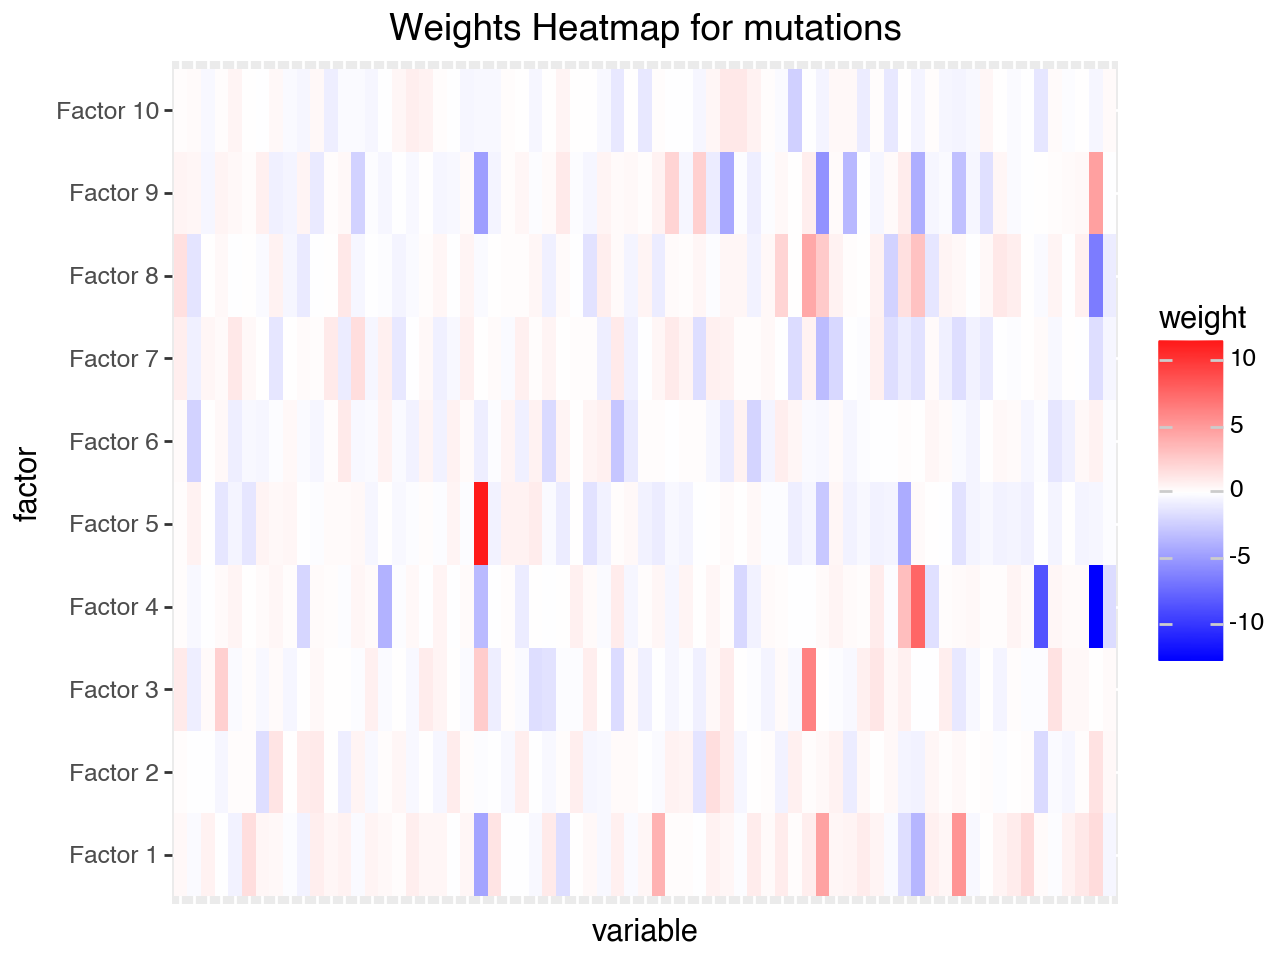

In [18]:
for modality in weights.keys():
    df_plot = weights[modality].reset_index(names="factor").melt(id_vars="factor", var_name="variable", value_name="weight")
    df_plot["factor"] = pd.Categorical(df_plot["factor"], categories=[f"Factor {i+1}" for i in range(weights[modality].shape[0])], ordered=True)

    plot = (
        p9.ggplot(df_plot, p9.aes(x="variable", y="factor", fill="weight"))
        + p9.geom_tile()
        + p9.scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0)
        + p9.theme(axis_text_x=p9.element_blank(), axis_ticks_x=p9.element_blank())
        + p9.labs(title=f"Weights Heatmap for {modality}")
    )
    plot.show()

### Exercise

You have now trained two MOFA-FLEX models, one with 10 factors and one with a smaller number. How similar are inidividual factors (in terms of their factor scores) between those two? To find this out, compute the Pearson correlation coefficient for each possible combination of factors across models to create a correlation matrix (shape `10 x smaller number of factors`). What do you see and does this match your expectations?

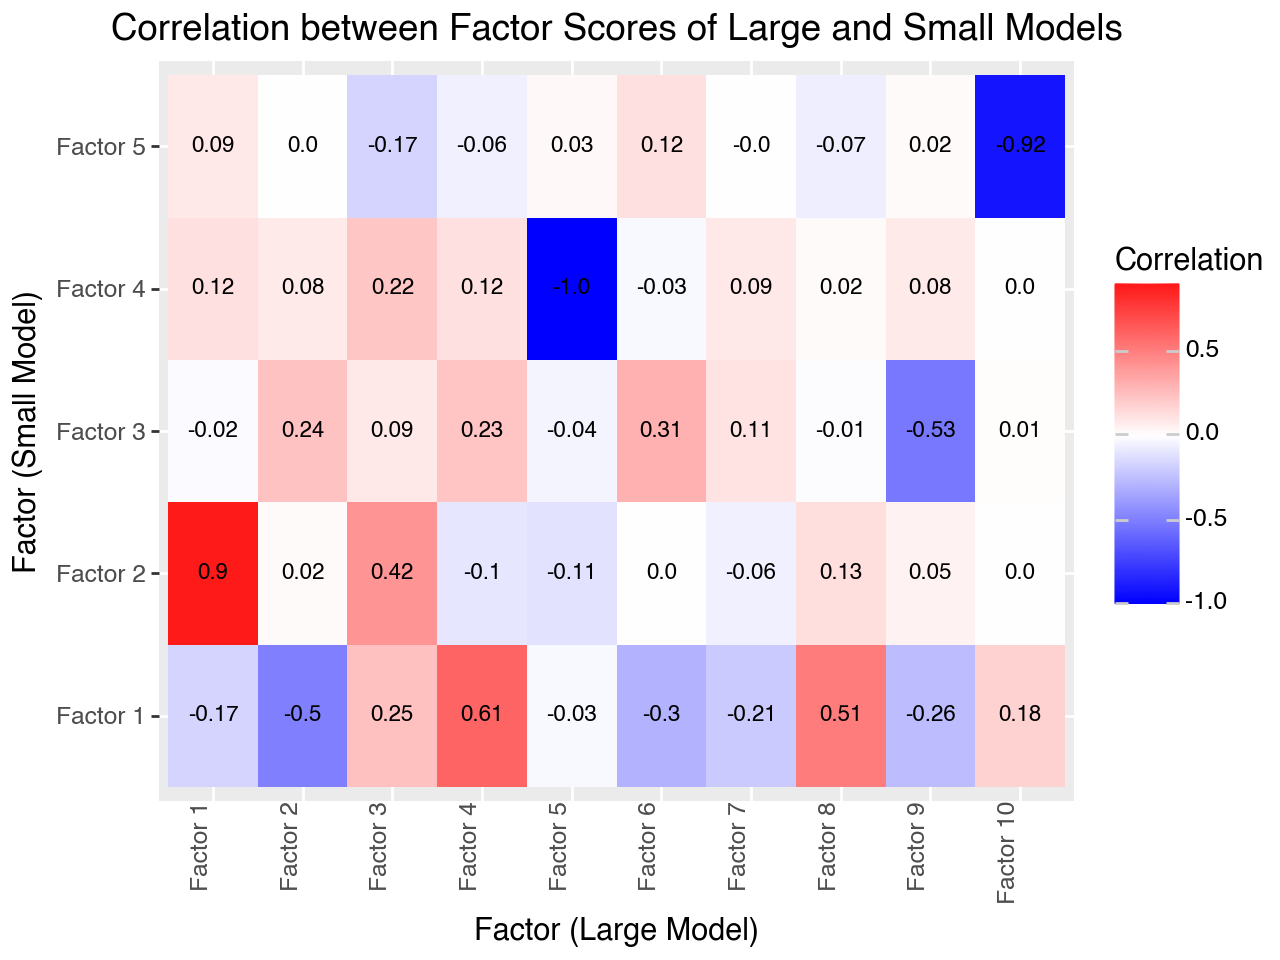

In [20]:
corr_matrix = np.zeros((model.n_factors, model_small.n_factors))

for factor in range(model.n_factors):
    for factor_small in range(model_small.n_factors):
        corr_matrix[factor, factor_small] = pearsonr(
            model.get_factors()["group_1"].iloc[:, factor],
            model_small.get_factors()["group_1"].iloc[:, factor_small],
        )[0]

df_plot = pd.DataFrame(
    corr_matrix,
    columns=[f"Factor {i+1}" for i in range(model_small.n_factors)],
    index=[f"Factor {i+1}" for i in range(model.n_factors)],
    ).reset_index(names="Factor").melt(id_vars="Factor", var_name="Factor Small", value_name="Correlation")
df_plot["Correlation"] = np.round(df_plot["Correlation"], 2)
df_plot["Factor"] = pd.Categorical(df_plot["Factor"], categories=[f"Factor {i+1}" for i in range(model.n_factors)], ordered=True)

plot = (
    p9.ggplot(df_plot, p9.aes(x="Factor", y="Factor Small", fill="Correlation"))
    + p9.geom_tile()
    + p9.scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0)
    + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1), axis_ticks_x=p9.element_blank())
    + p9.labs(
        title="Correlation between Factor Scores of Large and Small Models",
        x="Factor (Large Model)",
        y="Factor (Small Model)",
    )
    + p9.geom_text(p9.aes(label="Correlation"), color="black", size=8)
)
plot.show()

### Exercise

1. Let's now look at individual factors. You can use the `mf.pl.factors_scatter` method to make a scatterplot of the factor scores of one factor vs another. Do this for the two factors in the first model (the one with 10 factors). Do you see any structure?
2. If there are observation covariates, it makes sense to color the scatterplot according to these to explore whether the observed structure corresponds to any of the covariates. This is done using the `color` argument of the plotting function, which can be given the column name of the respective covariate in the `.obs` DataFrame of the original input data. Try this for the different available covariates and see whether you can find something!
3. Can you find a factor that separates patients by their trisomy12 status?

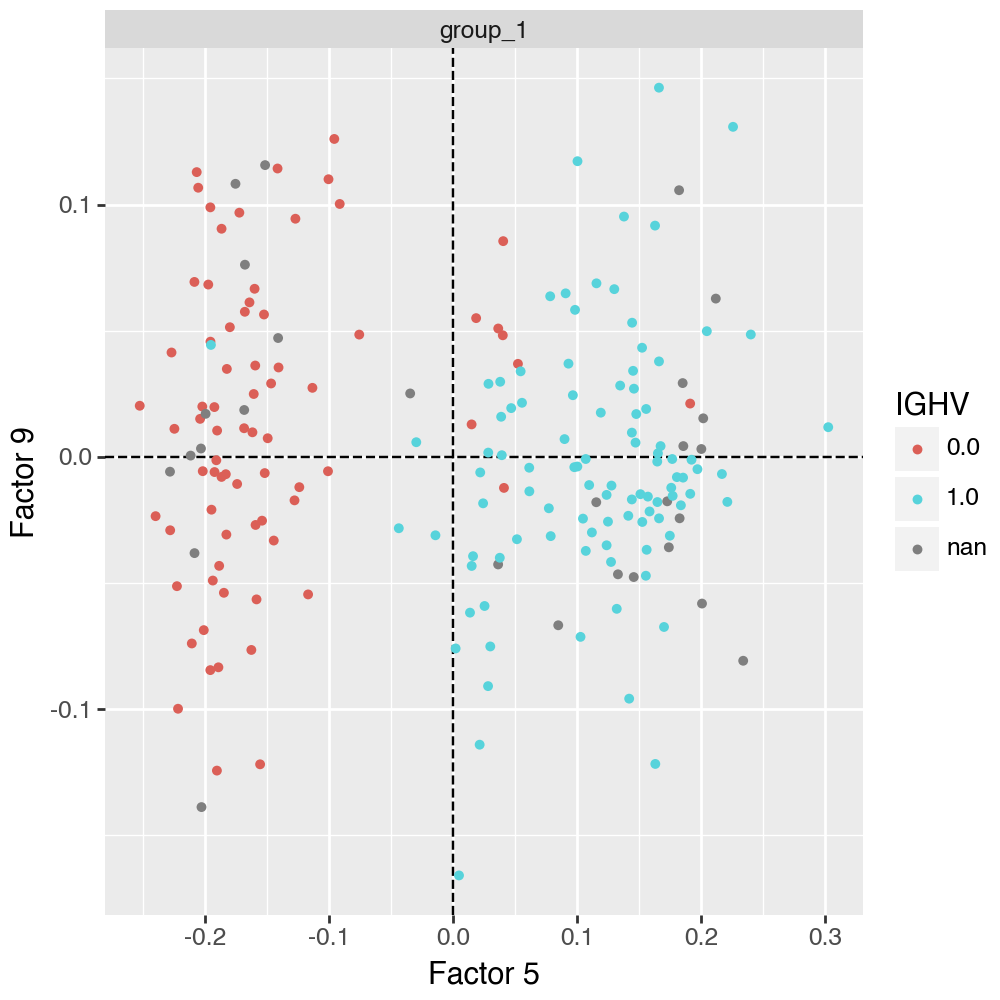

In [44]:
mf.pl.factors_scatter(model, "Factor 5", "Factor 9", color="IGHV")

### Exercise

You have probably seen that not all patients have known IGHV status (they just have a NaN in the corresponding column). However, you just found a factor that separates patients by their IGHV status! How about predicting IGHV status for the missing patients from the factor scores of this factor? Use a simple classification algorithm from scikit-learn, such as `KNeighborsClassifier`. This algorithm takes as input the factor scores for the relevant factor and decides for each of the missing patients based on a majority vote of the surrounding patients (surrounding means closest factor scores). Hint: Use only the patients with known IGHV status as a training set, and then predict IGHV status on the full data set.

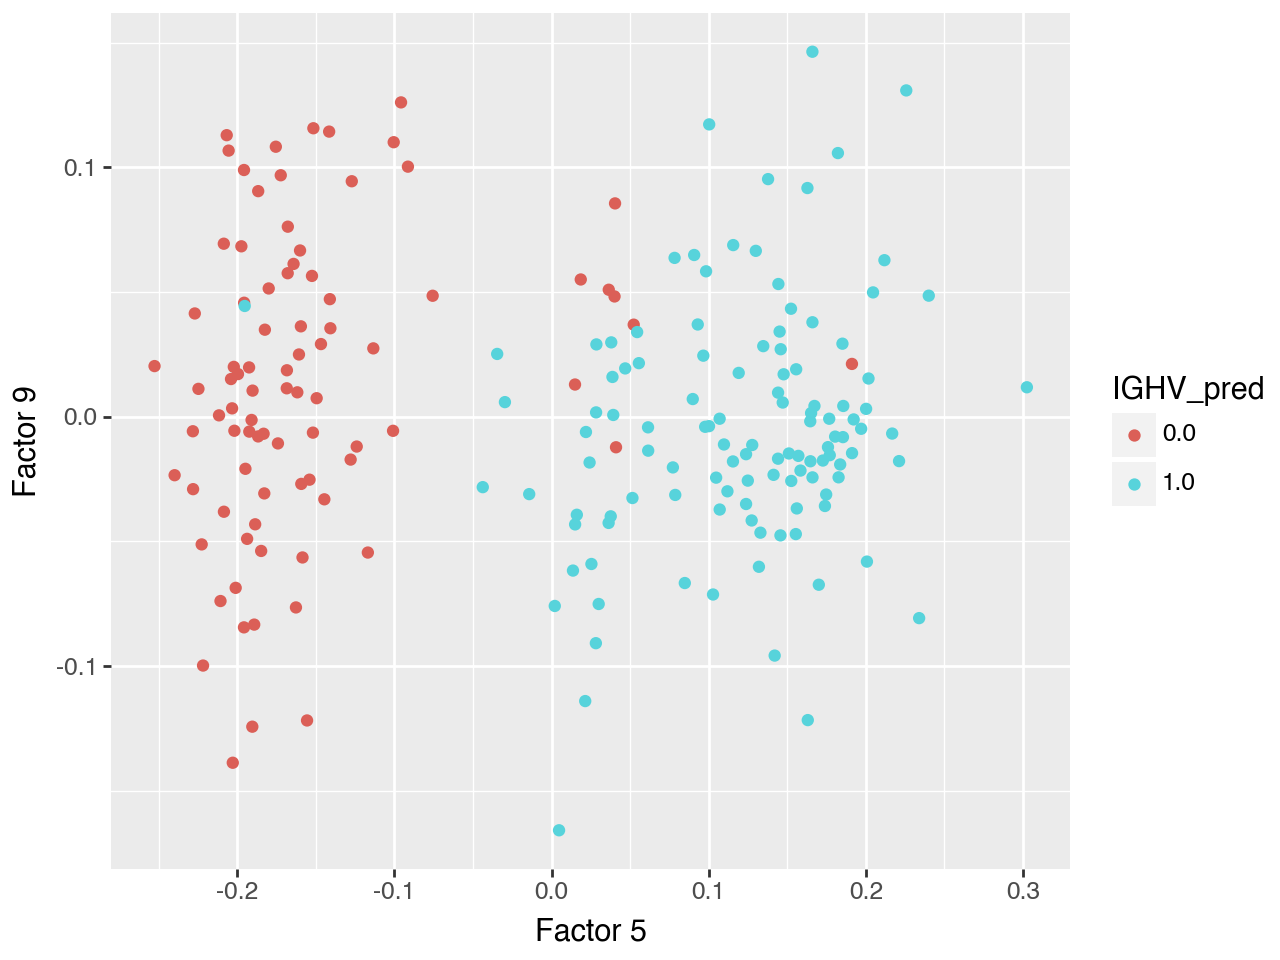

In [76]:
factors = model.get_factors(return_type="anndata")["group_1"]
train_inds = factors.obs["IGHV"].notna()

X = factors.to_df().loc[:, "Factor 5"].values.reshape(-1, 1)
X_train = X[train_inds]
y_train = factors.obs.loc[train_inds, "IGHV"].values

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X)
factors.obs.loc[:, "IGHV_pred"] = y_pred
factors.obs.loc[train_inds, "IGHV_pred"] = y_train

df_plot = pd.merge(factors.to_df(), factors.obs[["IGHV", "IGHV_pred"]], left_index=True, right_index=True)

plot = (
    p9.ggplot(df_plot, p9.aes(x="Factor 5", y="Factor 9", color="IGHV_pred"))
    + p9.geom_point()
)
plot.show()

Now that you found which factors stratify the patients into several groups, you should have a closer look at the corresponding factor weights. The weights describe how each original variable (gene, methylation site, ...) is associated with an individual factor. Also note that both the factor scores and weights can be positive or negative. Switching the signs of both the scores and the weights for a factor will not make a difference because the $-1 * -1 = 1$. But in general, the sign is important because it tells us about the direction of an effect. For example, if the sign of the factor weights for gene A is positive, and for gene B is negative, an increased activity (as measured by the factor score) of this factor in a given sample has opposite effects on the values of those genes in the data.

## Exercise
Use the `mf.pl.top_weights` function to plot the highest (absolute) weights of the factor that you found to separate patients by IGHV status. Plot the weights for the different modalities (views). What can you conclude about e.g. a drug with a high weight in the drugs view? How is it related to IGHV status and can you make predictions about drug efficacy from this? What role does the sign of the weight play?

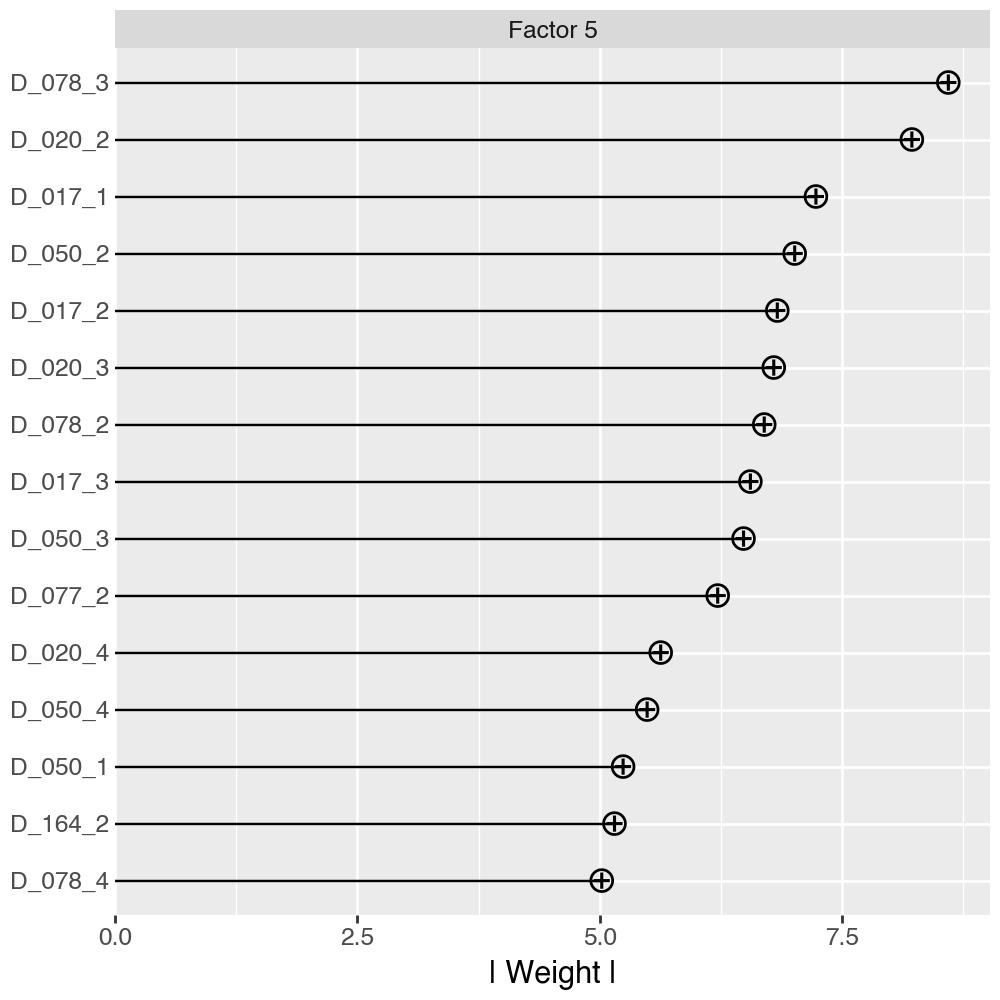

In [87]:
mf.pl.top_weights(model, 15, "drugs", "Factor 5")

Finally, we want to try assigning biological meaning to the factors that we found. This could e.g. be a pathway that comprises a number of the original data variables. This is done by looking at the factor weights. For each factor, we can sort the weights by their absolute value and do a gene set enrichment analysis with the top hits.

### Exercise
1. Get the factor weights for the mRNA view and sort the genes by their absolute value.
2. Use GSEAPY (use the [prerank module](https://gseapy.readthedocs.io/en/latest/gseapy_example.html#Prerank-example)) to perform an enrichment analysis of gene sets in the Reactome data base. Inspect the results and try to make biological sense of them.

In [177]:
rank = model.get_weights()["mrna"].T
rank.index = adata_mrna.var.gene_name
rank_abs = np.abs(rank)
rank_abs.sort_values(by="Factor 5", ascending=False, inplace=True)

pre_res = gp.prerank(
    rnk=rank_abs["Factor 5"],
    gene_sets=gp.get_library("Reactome_2022", organism="Human"),
    outdir=None,
)

pre_res.res2d.head(10)

2025-07-03 12:43:25,998 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,RHOF GTPase Cycle R-HSA-9035034,0.799283,1.685672,0.0,0.02911,0.023,7/19,5.70%,SOWAHC;AKAP12;CAV1;FARP1;SLC4A7;ARHGAP39;ADD3
1,prerank,RHOD GTPase Cycle R-HSA-9013405,0.783072,1.640602,0.002012,0.056211,0.075,9/19,6.85%,AKAP12;CAV1;CPNE8;SLC4A7;ARHGAP39;RHOD;PLXNB1;...
2,prerank,Extra-nuclear Estrogen Signaling R-HSA-9009391,0.713227,1.537267,0.002,0.308829,0.483,8/26,6.75%,CAV1;IGF1R;PTK2;GNGT2;GNG8;AREG;AKT3;GNB4
3,prerank,Signaling By ERBB2 R-HSA-1227986,0.721811,1.500872,0.011168,0.425852,0.644,6/15,11.91%,PRKCA;AKT3;GRB7;YES1;RNF41;PTK6
4,prerank,GPER1 Signaling R-HSA-9634597,0.723895,1.498179,0.012133,0.35614,0.667,7/16,15.18%,PRKCA;GNAZ;GNGT2;GNG8;GNB4;ADCY9;GNB3
5,prerank,G Alpha (12/13) Signaling Events R-HSA-416482,0.682058,1.488276,0.001001,0.348812,0.721,17/31,21.65%,KALRN;GNGT2;PLXNB1;GNG8;GNB4;ARHGEF4;ARHGEF10;...
6,prerank,GABA Receptor Activation R-HSA-977443,0.696815,1.458182,0.028197,0.476937,0.871,6/16,15.18%,KCNJ2;GNGT2;GNG8;GNB4;ADCY9;GNB3
7,prerank,Apoptotic Execution Phase R-HSA-75153,0.688731,1.420056,0.028398,0.699131,0.957,7/15,17.85%,PTK2;H1-0;H1-4;H1-5;LMNA;SATB1;H1-3
8,prerank,Ca2+ Pathway R-HSA-4086398,0.657411,1.418581,0.016064,0.631933,0.957,8/23,15.18%,TCF7;PRKCA;GNGT2;PDE6G;GNG8;GNB4;GNAO1;GNB3
9,prerank,G Alpha (Z) Signaling Events R-HSA-418597,0.678494,1.4182,0.032226,0.570948,0.957,7/17,15.18%,PRKCA;GNAZ;GNGT2;GNG8;GNB4;ADCY9;GNB3
